# Лабораторная работа 5
Градиентный бустинг с CatBoost

Выполнил: Гершевский Егор Владимирович, гр.6131-010402D

Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы.

In [2]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 48 kB/s 


In [3]:
import pandas as pd
import numpy as np
from catboost import *
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, mean_absolute_error, mean_squared_error
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from warnings import filterwarnings
filterwarnings("ignore")

In [36]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/diabetes.csv")

In [37]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


1 Применить классификатор CatBoostClassifier к вашему набору данных. Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование `pd.factorize` / `pd.get_dummies` здесь лишнее.

1) Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.

2) Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).

3) В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

In [39]:
df['BMI'] = df['BMI'].astype(int)
df = df.drop(['DiabetesPedigreeFunction'], axis=1)

In [40]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,6,148,72,35,0,33,50,1
1,1,85,66,29,0,26,31,0
2,8,183,64,0,0,23,32,1
3,1,89,66,23,94,28,21,0
4,0,137,40,35,168,43,33,1


In [41]:
X, y = df.drop("Outcome", axis=1), df["Outcome"]

In [42]:
features = list(range(0, X.shape[1]))
print(features)

[0, 1, 2, 3, 4, 5, 6]


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.35, random_state=42)

In [44]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    X_train, y_train,
    cat_features=features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Посмотрим на лучшие параметры модели, лучшую итерацию и выведем лучшие score по метрикам

In [45]:
print(f"Model is fitted: {model.is_fitted()}")
print(f"Model params: {model.get_params()}")
print(f"Best iteration: {model.get_best_iteration()}")
print(f"Best score: {model.best_score_}")

Model is fitted: True
Model params: {'iterations': 200, 'learning_rate': 0.15, 'random_seed': 63, 'custom_loss': ['AUC', 'Accuracy']}
Best iteration: 30
Best score: {'learn': {'Accuracy': 1.0, 'Logloss': 0.04413030811979137}, 'validation': {'Accuracy': 0.694, 'Logloss': 0.5778438440572304, 'AUC': 0.7282695931328076}}


Посчитаем значения метрик

In [46]:
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")
print(f"AUC: {roc_auc_score(y_test, model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, model.predict(X_test))}")
print(f"Recall: {recall_score(y_test, model.predict(X_test))}")

Accuracy: 0.684
AUC: 0.6014027496685044
Precision: 0.6086956521739131
Recall: 0.3146067415730337


ROC-AUC кривая

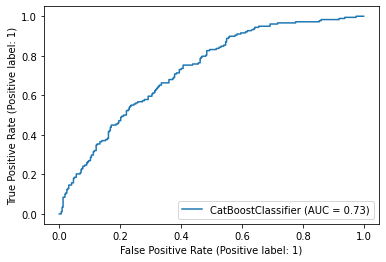

In [47]:
plot_roc_curve(model, X_test, y_test)

PRC-кривая и PRC-AUC

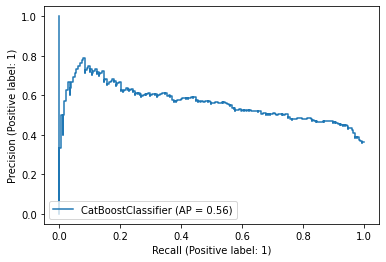

In [48]:
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="CatBoostClassifier")

2 Применить регрессию CatBoostRegressor к набору данных для регрессии. Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

In [49]:
model_regressor = CatBoostRegressor(
    custom_metric=["MAE", "RMSE"], 
    cat_features=features
)

model_regressor.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
print(f"Best iteration: {model_regressor.get_best_iteration()}")
print(f"Best score: {model_regressor.get_best_score()}")
print(f"Model params: {model_regressor.get_params()}")
print(f"MAE: {mean_absolute_error(y_test, model_regressor.predict(X_test))}")
print(f"MSE: {mean_squared_error(y_test, model_regressor.predict(X_test))}")

Best iteration: 157
Best score: {'learn': {'MAE': 0.06041099829651041, 'RMSE': 0.07813057604366098}, 'validation': {'MAE': 0.3755003849488953, 'RMSE': 0.4386788716572319}}
Model params: {'loss_function': 'RMSE', 'custom_metric': ['MAE', 'RMSE'], 'cat_features': [0, 1, 2, 3, 4, 5, 6]}
MAE: 0.37952844171565076
MSE: 0.19243915243846207
